# Exploring reddit data
---
- In this notebook my main aim is to get acquainted with the data in order to develop intuition about which features to use and what model to fit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import json
from time import time
import pickle
from collections import Counter
from spacy.lang.en import English

/Users/mananmehta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mananmehta/anaconda3/lib/

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [153]:
data = pd.read_csv("reddit-data.csv")   # importing csv file

In [4]:
data.head(5)

,title,score,body,url,num_comments,comments,flair,id
0,Delhi Govt Sources: Names of CM Arvind Kejriwa...,302,NaN,https://twitter.com/ANI/status/123109390051893...,30,This is beyond petty. > The inclusion of a De...,Scheduled,f7ogd8
1,"Delhi: AP Singh, advocate of 2012 Delhi gang-r...",17,NaN,https://twitter.com/ani/status/124073128907587...,22,"My hunch is , this guy is trying to expose th...",Scheduled,flgvah
2,Why the Supreme Court’s verdict on SC/ST quota...,106,NaN,https://scroll.in/article/952687/why-the-supre...,47,Muslims and reservation are two distractions ...,Scheduled,f1o839
3,What about the entrance exams scheduled in May?,9,"CLAT, AILET, NEET, JEE have been postponed bu...",https://www.reddit.com/r/india/comments/fvcvo1...,3,"Bachega India, tabhi toh Padhega India. Gand ...",Scheduled,fvcvo1
4,Advisory: No scheduled international commercia...,36,NaN,https://twitter.com/PIB_India/status/124061071...,4,Oh boy. Chalo bhaisahab. Sabji ka dukaan main...,Scheduled,fl8zf5


## 1. Finding where we have Missing Data
---

In [5]:
data.info()         # We can observe that there are many Nan objects in 'body' and some in 'comments' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 8 columns):
title           2227 non-null object
score           2227 non-null int64
body            1242 non-null object
url             2227 non-null object
num_comments    2227 non-null int64
comments        2008 non-null object
flair           2227 non-null object
id              2227 non-null object
dtypes: int64(2), object(6)
memory usage: 139.3+ KB


- The graph below shows that there are many null objects in body column, almost half of the values are null. This will lead to huge loss of data while training. So we will not consider body column for training.
  
    
- We can work with comments by removing null objects using data.dropna()

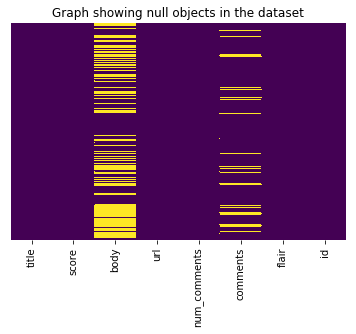

In [6]:
import seaborn as sns
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')  # Graph showing null objects
plt.title('Graph showing null objects in the dataset')
plt.show()

- We will be focusing our attention on the “Title”, "url", "comments" columns as they contain the most valuable qualitative information.

## 2. Creating a histogram across flair categories ( To understand distribution of our data )
---
- We can observe that almost all flairs have similar number of examples except **FoodBusiness/Finance** and **CAA-NRC-NPR**

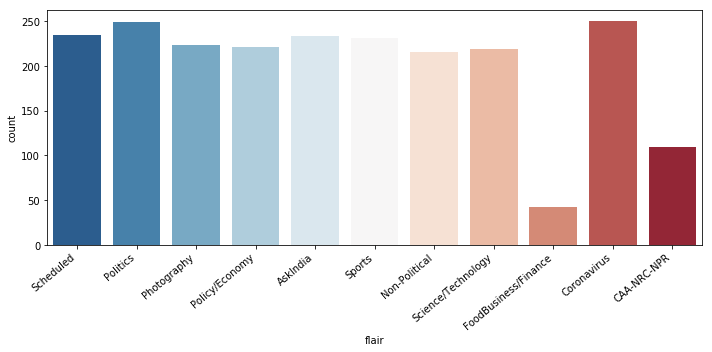

In [7]:
plt.figure(figsize = (10,5))
ax = sns.countplot(x='flair',data=data,palette='RdBu_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [8]:
data['flair'].value_counts()

Coronavirus             250
Politics                249
Scheduled               234
AskIndia                233
Sports                  231
Photography             223
Policy/Economy          221
Science/Technology      219
Non-Political           216
CAA-NRC-NPR             109
FoodBusiness/Finance     42
Name: flair, dtype: int64

# 3. Text Preprocessing 
---

In [9]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

In [10]:
from nltk.stem.wordnet import WordNetLemmatizer 
wnl = WordNetLemmatizer() 

In [11]:
def lemmatise(sent):              
    sent = nltk.tag.pos_tag(sent)
    sent = [(w,get_wordnet_pos(p)) for (w,p) in sent]
    sent = [wnl.lemmatize(w,tag) for (w,tag) in sent]
    return sent

def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
def text_cleaning(sent):
    sent = sent.lower()   #converting to lower case
    sent = re.sub("[^a-zA-Z]+|(pdf|html|www|http|jpg|com)"," ",sent) # removing numbers and punctuation
    sent = sent.split()
    
    sent = [w for w in sent if len(w)>1] # removing words of length 1 
    sent = [w for w in sent if w not in stopwords_set] # removing stopwords
    sent = lemmatise(sent)    # lemmatization
    sent = " ".join(sent)
    return sent

## 3.1 Text Preprocessing of Titles
---

In [13]:
data['title_new'] = data['title'].apply(text_cleaning)  

In [14]:
print("old --> ",data['title'][98],"\n\nnew --> ",data['title_new'][98])

old -->  Working people of Randia, don't you get bored of your whole day schedule as it's nearly the same everyday ? Doesn't it becomes quite dull ? 

new -->  work people randia get bored whole day schedule nearly everyday es quite dull


## 3.2 Text preprocessing of comments
---
- some comments are very long the longest being 5,56,983. So, I will limit comments to 10,000 characters which will   still completely cover 96% of comments i.e 96% of comments will remain as it is. 

In [15]:
data['comments'].fillna("").apply(len).describe(percentiles=[.96,.25,.75])

count      2227.000000
mean       3292.672205
std       20587.900732
min           0.000000
25%         243.500000
50%         918.000000
75%        2430.500000
96%        9885.640000
max      556983.000000
Name: comments, dtype: float64

In [16]:
def clear_comments(comment):       # function to limit comment length to 10000 characters
    if(len(comment) > 10000):
        return comment[:10000]
    return comment

In [17]:
data['comments_new'] = data['comments'].fillna("").apply(clear_comments).apply(text_cleaning)

- After preprocessing :- 

In [18]:
data['comments_new'].fillna("").apply(len).describe()

count    2227.000000
mean     1186.520880
std      1547.666959
min         0.000000
25%       150.500000
50%       551.000000
75%      1502.000000
max      7296.000000
Name: comments_new, dtype: float64

In [19]:
print("old --> ",data['comments'][14],"\n\nnew --> ",data['comments_new'][14])

old -->   Bangladesh is literally the only friendly neighbor we have..god forbid they allow China access to their ports. The way our government is spreading hate against Bangladesh, it seems possible Disgusting...Really Pathetic by BJP and Tadipaar Amit Shah to portray Bangladesh, Afghanistan as states that persecute their minorities. No country in world would welcome such remarks. But Our Bhadva Home Minister blatantly accused our neighbors of such wrong doings. 

Now Good luck you fucktards in Government with creating good relationship with our neighbors when China is hounding them one by one. Such a Mess. 

new -->  bangladesh literally friendly neighbor god forbid allow china access port way government spread hate bangladesh seem possible disgust really pathetic bjp tadipaar amit shah portray bangladesh afghanistan state persecute minority country world would wel remark bhadva home minister blatantly accuse neighbor wrong doings good luck fucktards government create good relationsh

## 3.3 Text preprocessing of url
---
- Text cleaning of url requires extracting meaningful words from url and removing all the noise like (www, https, jpg, .com , etc.) such words are very common and do not help in distinguishing among different flairs

In [20]:
def regex_on_url(text):    # custom regex to extract of only meaningful words from url
    return re.sub("(https://)|[a-z.]+(com)|[^a-zA-Z]|(pdf|html|www|http|jpg)",' ',text)

def clean_url(text):
    text = text.lower()       # converting to lowercase
    text = regex_on_url(text) # regex
    text = text.split()
    
    text = [w for w in text if len(w)>1] # removing words of length 1 
    text = [w for w in text if w not in stopwords_set] # removing stopwords
    text = " ".join(text)
    return text

In [21]:
data['url_new'] = data['url'].apply(clean_url)

In [22]:
print("old --> ",data['url'][108],"\n\nnew --> ",data['url_new'][108])

old -->  https://www.reddit.com/r/india/comments/fndf09/fight_covid19/ 

new -->  india comments fndf fight covid


## preprocessing done !
- Now lets look at the dataset
---

In [23]:
data['title'] = data['title_new']
data['comments'] = data['comments_new']
data['url'] = data['url_new']
data = data.drop(['title_new','comments_new','url_new'],axis = 1)
data.head(5)

,title,score,body,url,num_comments,comments,flair,id
0,delhi govt source names cm arvind kejriwal dep...,302,NaN,ani status,30,beyond petty inclusion delhi government school...,Scheduled,f7ogd8
1,delhi ap singh advocate delhi gang rape convic...,17,NaN,ani status,22,hunch guy try expose loophole legal system nev...,Scheduled,flgvah
2,supreme court verdict sc st quota create polit...,106,NaN,scroll article supreme courts verdict sc st qu...,47,muslim reservation two distraction use indian ...,Scheduled,f1o839
3,entrance exam schedule may,9,"CLAT, AILET, NEET, JEE have been postponed bu...",india comments fvcvo entrance exams scheduled may,3,bachega india tabhi toh padhega india gand mar...,Scheduled,fvcvo1
4,advisory schedule international mercial passen...,36,NaN,pib india status,4,oh boy chalo bhaisahab sabji ka dukaan main da...,Scheduled,fl8zf5


# 4. Data Analysis
---
## 4.1 What flairs tell about scores
---

In [24]:
df = data.copy() 

In [25]:
df['score'].describe(percentiles = [0.96]) 

count     2227.000000
mean       139.941626
std        670.222072
min          0.000000
50%         26.000000
96%        585.920000
max      17783.000000
Name: score, dtype: float64

In [26]:
# removing scores greater than 500 because there are very few outliers greater than 600.
# These outliers are very large and they squash the boxplot making it unreadable.
df = df[df['score'] < 600] 

- The median score length of **Politics** is the highestfollowed by **FoodBusiness/Finance** and **CAA-NRC-NPR**

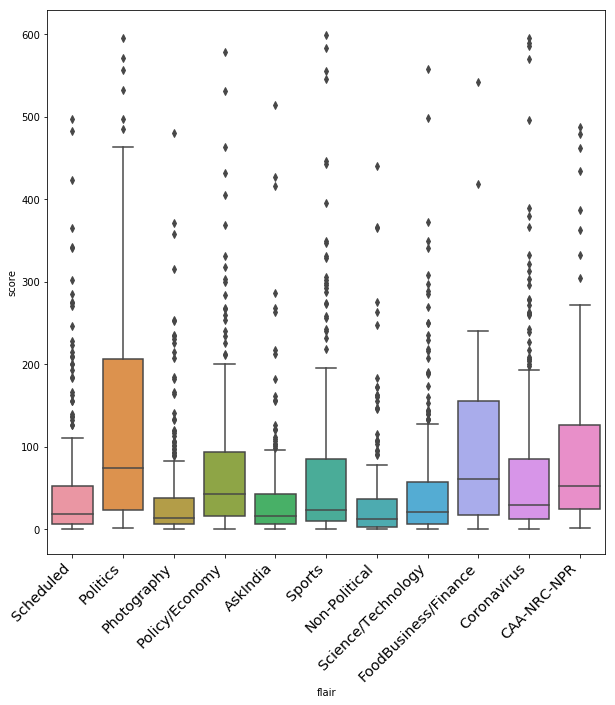

In [27]:
plt.figure(figsize = (10,10))
graph = sns.boxplot(x = df['flair'],y = df['score'])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

## 4.2 What flairs tell about num_comments
---

In [28]:
df = data.copy() 

- 99% of num_comments are below 400.
- So, it makes sense to remove outliers above 400 it would make boxplot readable.

In [29]:
df['num_comments'].describe(percentiles = [.99,.75,.25])

count     2227.000000
mean        47.920521
std        338.008171
min          0.000000
25%          3.000000
50%         11.000000
75%         34.000000
99%        353.920000
max      11006.000000
Name: num_comments, dtype: float64

In [30]:
df = df[df['num_comments'] < 400]

- The median num_comments is highest for politics

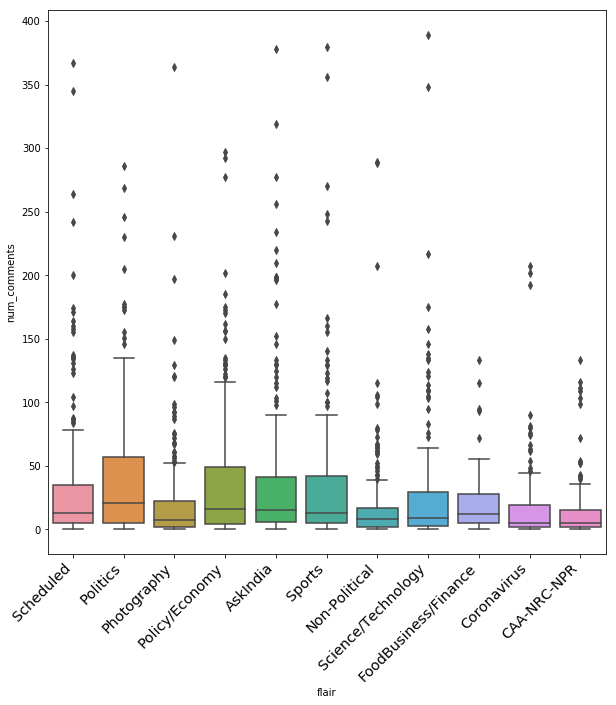

In [31]:
plt.figure(figsize = (10,10))
graph = sns.boxplot(x = df['flair'],y = df['num_comments'])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

## 4.3 lets introduce a new column in dataset "word_length"
---
- word_length column will contain the combined length of (title + url + comments) for each row.   
- **we will use it to study the relation between word_length and flair categories**.

In [32]:
df = data.copy()

In [33]:
df['word_length'] = df[['title','url','comments']].apply(lambda x : ' '.join(x),axis = 1).apply(len)

In [34]:
df.head(5)

,title,score,body,url,num_comments,comments,flair,id,word_length
0,delhi govt source names cm arvind kejriwal dep...,302,NaN,ani status,30,beyond petty inclusion delhi government school...,Scheduled,f7ogd8,1301
1,delhi ap singh advocate delhi gang rape convic...,17,NaN,ani status,22,hunch guy try expose loophole legal system nev...,Scheduled,flgvah,408
2,supreme court verdict sc st quota create polit...,106,NaN,scroll article supreme courts verdict sc st qu...,47,muslim reservation two distraction use indian ...,Scheduled,f1o839,2069
3,entrance exam schedule may,9,"CLAT, AILET, NEET, JEE have been postponed bu...",india comments fvcvo entrance exams scheduled may,3,bachega india tabhi toh padhega india gand mar...,Scheduled,fvcvo1,243
4,advisory schedule international mercial passen...,36,NaN,pib india status,4,oh boy chalo bhaisahab sabji ka dukaan main da...,Scheduled,fl8zf5,211


In [35]:
df['word_length'].describe() 

count    2227.000000
mean     1299.523574
std      1545.895236
min        23.000000
25%       264.000000
50%       676.000000
75%      1616.000000
max      7397.000000
Name: word_length, dtype: float64

- The median word length of **Policy/Economy** is the greatest followed by **Science/Technology**

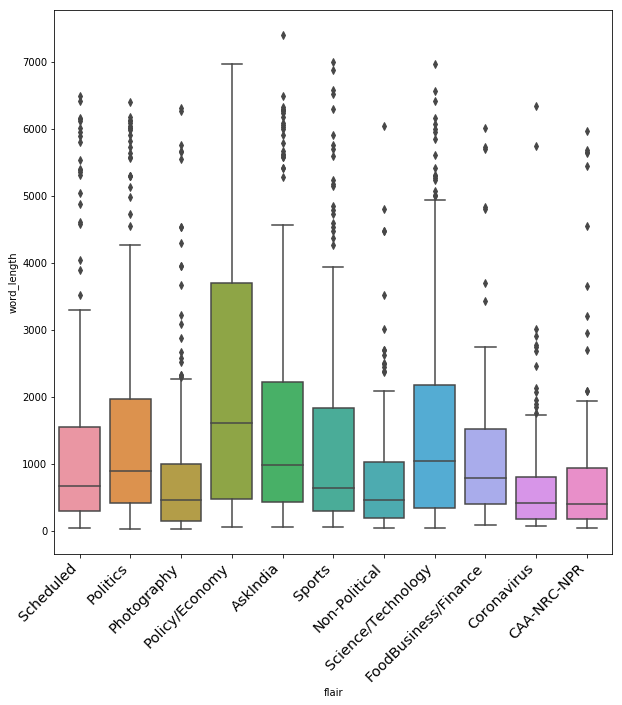

In [36]:
plt.figure(figsize = (10,10))
graph = sns.boxplot(x = df['flair'],y = df['word_length'])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

## 4.4 jointplot of word_length and score
---
- This plot will give us the relationship between word_length and score 

In [37]:
df_without_outliers = df[(df['score'] < 600) & (df['word_length'] < 6000)] # filtering outliers

- Pearson's correlation coefficient = 0.29 which suggests there is some positive linear correlation between them but not too much.

/Users/mananmehta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is d

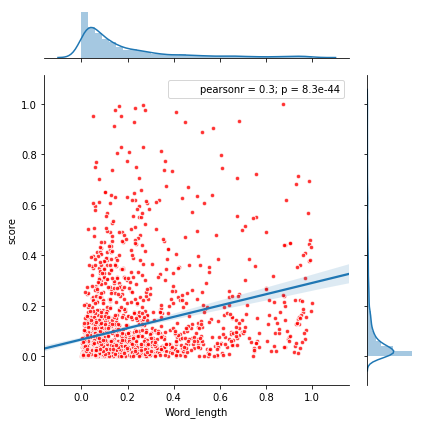

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(np.reshape(df_without_outliers['word_length'].values,(-1,1)))
Y = scaler.fit_transform(np.reshape(df_without_outliers['score'].values,(-1,1)))

sns.jointplot(x = X,y = Y, kind = 'reg',scatter_kws = {'s':20,'edgecolor':'w','color':'r'})
plt.xlabel('Word_length')
plt.ylabel('score')
plt.tight_layout()
plt.show()

## 4.5 jointplot of word_length and num_comments
---
- This plot will give us the relationship between word_length and num_comments 

In [39]:
df[['num_comments','word_length']].describe(percentiles=[.95])

,num_comments,word_length
count,2227.000000,2227.000000
mean,47.920521,1299.523574
std,338.008171,1545.895236
min,0.000000,23.000000
50%,11.000000,676.000000
95%,129.000000,5377.300000
max,11006.000000,7397.000000


In [40]:
df_without_outliers = df[(df['num_comments'] < 130) & (df['word_length'] < 6000)]

- Pearson correlation coefficient has a value of **0.65** which indicates a high level of +ve linear correlation between word_length and num_comments 
  
     
- We can say that as the word_length increases the num_comments increases, this is mainly due to to length of (comments). It is understandable that if length of (comments) will increase then num_comments will increase.

/Users/mananmehta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/mananmehta/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is d

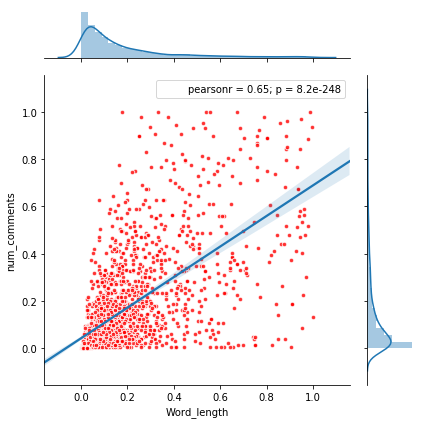

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(np.reshape(df_without_outliers['word_length'].values,(-1,1)))
Y = scaler.fit_transform(np.reshape(df_without_outliers['num_comments'].values,(-1,1)))

sns.jointplot(x = X,y = Y, kind = 'reg',scatter_kws = {'s':20,'edgecolor':'w','color':'r'})
plt.xlabel('Word_length')
plt.ylabel('num_comments')
plt.tight_layout()
plt.show() 

## 5. Content Analysis
---
- Lets analyze the words used by different categories and output some notable term associations. We will use scattertext and spaCy libraries.

In [42]:
complete_text = df[['title','url','comments']].apply(lambda x: ' '.join(x),axis = 1)

In [43]:
complete_text = ' '.join(complete_text.values)

## 5.1 Most common words in the whole dataset
--- 
- The most common word in the whole dataset is **'india'** which makes sense, as we took data from r/India subreddit.

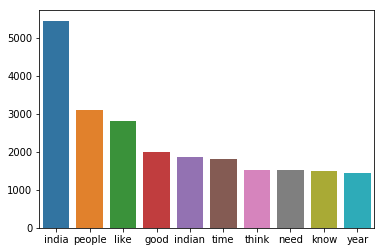

In [44]:
nlp = English()
nlp.max_length = 3000000
complete_doc = nlp(complete_text)
words = [token.text for token in complete_doc if not token.is_stop]
words_freq = Counter(words)

# Most common 10 words in entire dataset
top_10_words = words_freq.most_common(10)
x = []
y = []
for (word,count) in top_10_words:
    x.append(word)
    y.append(count)
   
sns.barplot(x=x, y=y)

## 5.2 Finding the most common words in each category
---

In [128]:
flairs = ['Scheduled', 'Politics', 'Photography', 'Policy/Economy','AskIndia', 'Sports', 'Non-Political', 'Science/Technology','FoodBusiness/Finance', 'Coronavirus', 'CAA-NRC-NPR']
complete_text_for_each_flair = {}   # dictionary which contains complete text (title + url + comments) for each flair
for f in flairs:
    text = df[df['flair'] == f][['title','url','comments']].apply(lambda x : ' '.join(x),axis = 1)
    text = ' '.join(text.values)
    complete_text_for_each_flair[f] = text

- Most flairs have **India** among its top common words.
- these results make sense and indicate that each flair category contains some words that can help distinguish them, for example :-
  1. **Scheduled**            --> 'caste'  
  2. **Politics**             --> 'bjp'
  3. **Photography**          --> 'photography', 'like'
  4. **Policy/Economy**       --> 'economy'
  5. **Sports**               --> 'sport'
  6. **Science/Technology**   --> 'science', 'technology'
  7. **FoodBusiness/Finance** --> 'week'
  8. **Coronavirus**          --> 'coronavirus'
  9. **CAA-NRC-NPR**          --> 'caa', 'nrc'

In [46]:
print("Top 3 words in each flair are :- ",end = '\n\n')
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    words = [token.text for token in doc if not token.is_stop]
    word_freq = Counter(words)
    top_3_words = word_freq.most_common(3)
    print(f,"-->",top_3_words,end = '\n\n')

Top 3 words in each flair are :- 

Scheduled --> [('india', 443), ('people', 302), ('caste', 270)]

Politics --> [('people', 569), ('india', 548), ('bjp', 459)]

Photography --> [('photography', 354), ('india', 339), ('like', 200)]

Policy/Economy --> [('india', 1144), ('economy', 571), ('people', 466)]

AskIndia --> [('india', 655), ('like', 420), ('people', 379)]

Sports --> [('india', 622), ('sport', 560), ('like', 399)]

Non-Political --> [('india', 344), ('political', 310), ('non', 301)]

Science/Technology --> [('india', 691), ('science', 517), ('technology', 375)]

FoodBusiness/Finance --> [('india', 126), ('week', 88), ('good', 80)]

Coronavirus --> [('coronavirus', 456), ('india', 344), ('people', 256)]

CAA-NRC-NPR --> [('caa', 235), ('nrc', 227), ('india', 200)]



## 5.3 Using dependency parsing to find what  India is talking about, what India is doing ?
---
- We will use Spacy's dependecy parsing to find the objects, subjects, verbs for each flair :-
  1. First, we will first find the most common OBJECTS , **This will tell us what india is talking about.**
  2. Second, we will find the most common VERBS , **This will tell us what india is doing.**
  3. Third, we will find the most common SUBJECTS, **This will tell us about entities in text.**

### Dependency Parsing
---
- Dependency parsing is the task of extracting grammatical structure of a text, it consists of relations between "root" words and words.
- For Example:-
  1. In the example below we show the dependency tree of the sentence - "He is playing football !"
  2. We can see that the words "He", "is", "football!" are all linked to the the VERB **playing**
  3. The image shows you that the subject of the sentence is the proper noun 'He' and it has a 'play' relationship with object 'football'.

In [47]:
import spacy
from spacy import displacy
nlp = spacy.load('en')
doc = nlp("He is playing football!")
for token in doc:
    print(token.text," ---- ", token.pos_," ---- ", token.head.text," ---- ", token.dep_)
displacy.render(doc,jupyter = True)

He  ----  PRON  ----  playing  ----  nsubj
is  ----  AUX  ----  playing  ----  aux
playing  ----  VERB  ----  playing  ----  ROOT
football  ----  NOUN  ----  playing  ----  dobj
!  ----  PUNCT  ----  playing  ----  punct


- We will try to find a similar dependancy relationship for each flair.
- We will look for token.dep_ , they tell us about the relationships of each token with its headword. In the example above headword was 'playing'. Generally headwords are VERBS.
- We will look at the following dependency labels (token.dep_) for eachtask :-
  1. OBJECT :- dobj (direct-object), obj(object), pobj (object-of-preposition)
  2. VERB :- we will extract headwords
  3. NOUN :- nsubj (nominal-subject), nsubjpass (nominal-subject-passive), csubj (clausal-subject), csubjpass (clausal-subject-passive)

### 5.3.1 Most common objects
---
- let's see what India is talking about in each flair:-

In [48]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    objects = []
    for token in doc:
        if (token.dep_ == 'dobj' or token.dep_ == 'obj' or token.dep_ == 'pobj'):
            objects.append(token.text)
        

    objects = Counter(objects)
    top_5 = objects.most_common(5)
    print(f,"-->",top_5,end = '\n\n')

Scheduled --> [('time', 52), ('caste', 44), ('game', 44), ('people', 39), ('reservation', 38)]

Politics --> [('people', 75), ('thing', 65), ('india', 59), ('politics', 58), ('time', 53)]

Photography --> [('photography', 59), ('comments', 39), ('work', 33), ('thing', 33), ('india', 33)]

Policy/Economy --> [('economy', 108), ('india', 98), ('country', 72), ('people', 64), ('time', 64)]

AskIndia --> [('comments', 72), ('time', 71), ('thing', 64), ('india', 58), ('use', 56)]

Sports --> [('sport', 63), ('india', 56), ('people', 41), ('comments', 40), ('thing', 40)]

Non-Political --> [('comments', 42), ('time', 25), ('thing', 24), ('people', 22), ('india', 22)]

Science/Technology --> [('technology', 64), ('india', 47), ('time', 43), ('comments', 40), ('science', 39)]

FoodBusiness/Finance --> [('comments', 15), ('post', 14), ('work', 13), ('thing', 12), ('time', 10)]

Coronavirus --> [('coronavirus', 37), ('people', 28), ('india', 24), ('country', 21), ('lockdown', 20)]

CAA-NRC-NPR -

### Random Objects
---

In [127]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    objects = []
    for token in doc:
         if (token.dep_ == 'dobj' or token.dep_ == 'obj' or token.dep_ == 'pobj'):
            objects.append(token.text)
        

    objects = Counter(objects)
    freq_cnt = dict(objects)
    sorted_verbs = sorted(freq_cnt.items(),key = lambda x : x[1])
    sorted_verbs = [w[0] for w in sorted_verbs if w[1] > 10]
    idx = np.random.randint(0, len(sorted_verbs), size=(5,))
    print(f, " -----> ",end = '')
    for i in idx:
        print(sorted_verbs[i],end = ', ')
       
    print('\n')

Scheduled  -----> help, game, way, watch, anyone, 

Politics  -----> people, bjp, situation, source, election, 

Photography  -----> ments, life, edit, india, day, 

Policy/Economy  -----> data, sector, ments, history, findia, 

AskIndia  -----> way, parent, hindi, post, flair, 

Sports  -----> work, league, reason, school, thing, 

Non-Political  -----> comments, life, place, money, time, 

Science/Technology  -----> student, place, way, world, system, 

FoodBusiness/Finance  -----> work, thing, work, work, work, 

Coronavirus  -----> something, day, thing, worker, day, 

CAA-NRC-NPR  -----> comments, comments, caa, comments, thing, 



### 5.3.2 Most common verbs
---
- let's see what India is doing :-
  - It's hard to make any inference from this output, the most common actions are very general.
  - Perhaps this indicates the nature of our text, It mainly consists of people reporting and posting things about India. We can expect that the most common verbs to be the very general ones i.e the ones we mostly use in everyday life. 

In [92]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    verbs = []
    for token in doc:
        if (token.dep_ == 'ROOT'):
            if(token.is_stop == False):
                verbs.append(token.text)
        

    verbs = Counter(verbs)
    top_5 = verbs.most_common(5)
    print(f,"-->",top_5,end = '\n\n')

Scheduled --> [('think', 84), ('want', 77), ('know', 70), ('play', 66), ('look', 48)]

Politics --> [('think', 142), ('know', 87), ('want', 84), ('need', 73), ('let', 61)]

Photography --> [('want', 63), ('look', 58), ('know', 55), ('think', 52), ('try', 37)]

Policy/Economy --> [('think', 136), ('know', 98), ('want', 84), ('need', 62), ('mean', 52)]

AskIndia --> [('know', 123), ('think', 121), ('need', 91), ('want', 83), ('try', 72)]

Sports --> [('think', 123), ('know', 72), ('watch', 71), ('want', 58), ('need', 50)]

Non-Political --> [('think', 62), ('know', 47), ('want', 45), ('comments', 25), ('try', 22)]

Science/Technology --> [('think', 90), ('know', 80), ('want', 72), ('need', 66), ('try', 43)]

FoodBusiness/Finance --> [('think', 25), ('know', 21), ('need', 15), ('find', 12), ('want', 11)]

Coronavirus --> [('think', 42), ('need', 28), ('let', 25), ('want', 24), ('ask', 23)]

CAA-NRC-NPR --> [('think', 34), ('need', 19), ('know', 19), ('let', 15), ('want', 14)]



### Random verbs
---
- This provides us a better view of actions that a flair can be involved in
  - Politics --> speak, win, face
  - Photography --> comments
  - Policy/Economy  --> suggest, grow, hope
  - AskIndia  --> tell, understand
  - Sports  --> beat
  - Science/Technology  --> write, try
  - Coronavirus  --> use, test
  - CAA-NRC-NPR  --> protest

In [123]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    verbs = []
    for token in doc:
        if (tovken.dep_ == 'ROOT'):
            if(token.is_stop == False):
                verbs.append(token.text)
        

    verbs = Counter(verbs)
    freq_cnt = dict(verbs)
    sorted_verbs = sorted(freq_cnt.items(),key = lambda x : x[1])
    sorted_verbs = [w[0] for w in sorted_verbs if w[1] > 10]
    idx = np.random.randint(0, len(sorted_verbs), size=(5,))
    print(f, " -----> ",end = '')
    for i in idx:
        print(sorted_verbs[i],end = ', ')
       
    print('\n')

Scheduled  -----> play, feel, wait, understand, find, 

Politics  -----> speak, win, let, face, forget, 

Photography  -----> comments, know, happen, feel, need, 

Policy/Economy  -----> suggest, grow, hope, use, suppose, 

AskIndia  -----> tell, include, yeah, askindia, understand, 

Sports  -----> find, leave, stop, yeah, beat, 

Non-Political  -----> think, believe, let, comments, know, 

Science/Technology  -----> comments, hear, write, try, try, 

FoodBusiness/Finance  -----> find, know, think, think, find, 

Coronavirus  -----> use, test, feel, mean, start, 

CAA-NRC-NPR  -----> know, protest, write, understand, let, 



### 5.3.3 Most common Subjects
---
- the subject is the part of a sentence that commonly indicates
    - what it is about
    - who or what performs the action

In [87]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    subjects = []
    for token in doc:
        if (token.dep_ == 'nsubj' or token.dep_ == 'nsubjpass' or token.dep_ == 'csubj' or token.dep_ == 'csubjpass'):
            if (token.text != 'people' and token.text != 'india'):  # people and india are the most common nouns in the dataset
                subjects.append(token.text)
        

    subjects = Counter(subjects)
    top_5 = subjects.most_common(5)
    print(f,"-->",top_5,end = '\n\n')

Scheduled --> [('anyone', 58), ('thing', 50), ('guy', 46), ('someone', 45), ('caste', 40)]

Politics --> [('bjp', 104), ('politics', 87), ('government', 79), ('modi', 71), ('thing', 69)]

Photography --> [('photography', 47), ('comments', 39), ('work', 32), ('guy', 31), ('everyone', 30)]

Policy/Economy --> [('government', 168), ('economy', 160), ('modi', 133), ('country', 101), ('thing', 72)]

AskIndia --> [('thing', 97), ('askindia', 78), ('life', 65), ('someone', 62), ('guy', 55)]

Sports --> [('sport', 56), ('someone', 54), ('country', 51), ('team', 48), ('thing', 47)]

Non-Political --> [('comments', 35), ('thing', 31), ('guy', 30), ('someone', 29), ('op', 21)]

Science/Technology --> [('technology', 53), ('government', 47), ('help', 46), ('thing', 42), ('science', 40)]

FoodBusiness/Finance --> [('post', 22), ('thing', 16), ('government', 13), ('one', 12), ('bank', 11)]

Coronavirus --> [('coronavirus', 68), ('government', 38), ('country', 31), ('doctor', 29), ('pm', 28)]

CAA-NR

### Random Subjects
---

In [126]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    subjects = []
    for token in doc:
        if (token.dep_ == 'nsubj' or token.dep_ == 'nsubjpass' or token.dep_ == 'csubj' or token.dep_ == 'csubjpass'):
                subjects.append(token.text)
        

    subjects = Counter(subjects)
    freq_cnt = dict(subjects)
    sorted_verbs = sorted(freq_cnt.items(),key = lambda x : x[1])
    sorted_verbs = [w[0] for w in sorted_verbs if w[1] > 15]
    idx = np.random.randint(0, len(sorted_verbs), size=(5,))
    print(f, " -----> ",end = '')
    for i in idx:
        print(sorted_verbs[i],end = ', ')
       
    print('\n')

Scheduled  -----> time, help, everyone, thing, schedule, 

Politics  -----> man, post, reason, problem, anyone, 

Photography  -----> someone, time, someone, time, op, 

Policy/Economy  -----> data, case, population, bot, economy, 

AskIndia  -----> u, work, thing, way, person, 

Sports  -----> cricket, something, movie, teacher, tv, 

Non-Political  -----> one, comments, people, one, thing, 

Science/Technology  -----> break, help, message, article, govt, 

FoodBusiness/Finance  -----> people, post, post, thing, india, 

Coronavirus  -----> pm, someone, delhi, doctor, india, 

CAA-NRC-NPR  -----> caa, india, bjp, npr, country, 



## 5.4 Most common bigrams, Trigrams
---

In [45]:
from nltk import bigrams, trigrams

In [46]:
nlp = English()
nlp.max_length = 3000000
complete_doc = nlp(complete_text)
unigrams = [token.text for token in complete_doc if not token.is_stop]

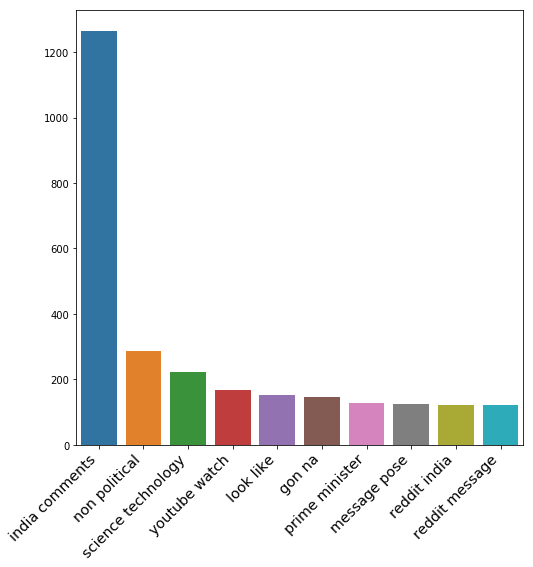

In [123]:
bi_grams = bigrams(unigrams)
bigram_list = []
temp = [w for w in bi_grams]
for x in temp:
    y = x[0]+' '+x[1]
    bigram_list.append(y)
   
bigram_freq = Counter(bigram_list)
bigram_top = bigram_freq.most_common(10)
x = []
y = []
for element in bigram_top:
    x.append(element[0])
    y.append(element[1])
   
plt.figure(figsize=(8,8))
sns.barplot(x = x,y = y)
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()    
    


In [135]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    unigrams = [token.text for token in doc if not token.is_stop]
    bi_grams = bigrams(unigrams)
    bigram_list = []
    temp = [w for w in bi_grams]
    for x in temp:
        y = x[0]+' '+x[1]
        bigram_list.append(y)

    bigram_freq = Counter(bigram_list)
    bigram_top = bigram_freq.most_common(6)
    print(f,"  ----->  ",bigram_top,end = '\n\n\n')
    

Scheduled   ----->   [('india comments', 154), ('youtube watch', 60), ('schedule caste', 40), ('sc st', 39), ('daily discussion', 38), ('random daily', 37)]


Politics   ----->   [('india comments', 86), ('political party', 39), ('amit shah', 36), ('look like', 35), ('shiv sena', 34), ('social medium', 29)]


Photography   ----->   [('india comments', 140), ('photography thread', 75), ('weekly photography', 67), ('thread thread', 54), ('look like', 24), ('youtube channel', 21)]


Policy/Economy   ----->   [('india comments', 140), ('indian economy', 79), ('prime minister', 50), ('long term', 50), ('narendra modi', 47), ('modi government', 45)]


AskIndia   ----->   [('india comments', 230), ('english hindi', 46), ('hindi english', 30), ('reddit india', 28), ('india ments', 26), ('gon na', 19)]


Sports   ----->   [('india comments', 135), ('world cup', 43), ('star sport', 40), ('virat kohli', 24), ('india india', 23), ('social medium', 20)]


Non-Political   ----->   [('non political',

## Top trigrams
---

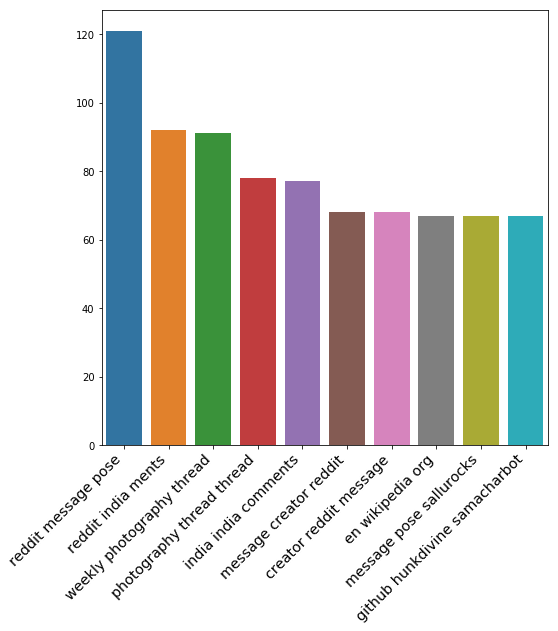

In [125]:
tri_grams = trigrams(unigrams)
trigram_list = []
temp = [w for w in tri_grams]
for x in temp:
    y = x[0]+' '+x[1]+' '+x[2]
    trigram_list.append(y)
   
trigram_freq = Counter(trigram_list)
trigram_top = trigram_freq.most_common(10)
x = []
y = []
for element in trigram_top:
    x.append(element[0])
    y.append(element[1])
   
plt.figure(figsize=(8,8))
sns.barplot(x = x,y = y)
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()    
    



In [136]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    unigrams = [token.text for token in doc if not token.is_stop]
    tri_grams = trigrams(unigrams)
    trigram_list = []
    temp = [w for w in tri_grams]
    for x in temp:
        y = x[0]+' '+x[1]+' '+x[2]
        trigram_list.append(y)

    trigram_freq = Counter(trigram_list)
    trigram_top = trigram_freq.most_common(5)
    print(f," -----> ",trigram_top,end = '\n\n\n')


Scheduled  ----->  [('random daily discussion', 37), ('schedule india comments', 32), ('thread schedule india', 26), ('weekly photography thread', 24), ('photography thread thread', 24)]


Politics  ----->  [('politics india comments', 10), ('reddit india ments', 10), ('twitter impression true', 8), ('bharat mata ki', 8), ('indiatoday india story', 7)]


Photography  ----->  [('weekly photography thread', 67), ('photography thread thread', 54), ('reddit india ments', 14), ('thread thread december', 10), ('thread thread september', 10)]


Policy/Economy  ----->  [('reddit message pose', 37), ('article adblocker unfriendly', 22), ('adblocker unfriendly follow', 22), ('unfriendly follow text', 22), ('follow text article', 22)]


AskIndia  ----->  [('reddit india ments', 25), ('india india comments', 15), ('askindia india comments', 13), ('nbsp nbsp nbsp', 13), ('covid megathread news', 11)]


Sports  ----->  [('india india comments', 20), ('star sport select', 10), ('accidental prime mini